<a href="https://colab.research.google.com/github/srak71/Image-To-Asyptote-Tuning/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Mount Drive and Imports
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time
import copy # For saving best model weights

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.preprocessing import LabelEncoder
# We are not doing detailed metrics here, just accuracy and loss during training
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For progress bar
!pip install tqdm -q
from tqdm.notebook import tqdm

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Device Name: Tesla T4


In [ ]:
# Cell 2: Configuration
BASE_DIR = "/content/drive/MyDrive/StarSparkProj" # Your project's base directory on Drive

TRAIN_METADATA_FILE = os.path.join(BASE_DIR, "train_metadata_Full.csv")
VAL_METADATA_FILE = os.path.join(BASE_DIR, "val_metadata_Full.csv")

# Path to load initial UNTRAINED model weights
INITIAL_MODEL_WEIGHTS_PATH = os.path.join(BASE_DIR, "untrained_resnet50_initial_weights.pth")

# Path to save the TRAINED model weights
TRAINED_MODEL_SAVE_PATH = os.path.join(BASE_DIR, "trained_resnet50_model_v1_10epochs.pth") # Added epoch info
BEST_MODEL_SAVE_PATH = os.path.join(BASE_DIR, "best_trained_resnet50_model_v1_10epochs.pth") # Added epoch info

# Model & Training Parameters
NUM_EPOCHS = 10 # <<<<< UPDATED FROM 20 to 10 >>>>>
BATCH_SIZE = 32
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_WORKERS = 2

# Determine device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

NUM_CLASSES = 0
FUNCTION_TYPES_ORDERED = []
global_label_encoder = LabelEncoder()


# --- Helper Function for plotting training results ---
def plot_training_results(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    if 'train_acc' in history and 'val_acc' in history:
        axs[0].plot(history['train_acc'], label='Train Accuracy')
        axs[0].plot(history['val_acc'], label='Validation Accuracy')
        axs[0].set_title('Accuracy over Epochs')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].legend()
        axs[0].grid(True)

    if 'train_loss' in history and 'val_loss' in history:
        axs[1].plot(history['train_loss'], label='Train Loss')
        axs[1].plot(history['val_loss'], label='Validation Loss')
        axs[1].set_title('Loss over Epochs')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
        axs[1].grid(True)

    plt.tight_layout()
    plt.show()
    plot_save_path = os.path.join(BASE_DIR, f"training_results_plot_{NUM_EPOCHS}epochs.png") # Filename reflects epochs
    fig.savefig(plot_save_path)
    print(f"Training plot saved to {plot_save_path}")

Using device: cuda


In [ ]:
# Cell 3: Custom Dataset Class
class AsymptoteDataset(Dataset):
    def __init__(self, metadata_df, transform=None, label_encoder=None):
        self.metadata_df = metadata_df.copy() # Use a copy
        self.transform = transform
        self.label_encoder = label_encoder # This will be a pre-fitted encoder
        self._missing_files_reported_this_worker = 0
        self._max_missing_file_warnings_per_worker = 5

        if 'function_type' in self.metadata_df.columns and self.label_encoder is not None:
            try:
                self.metadata_df['function_type_encoded'] = self.label_encoder.transform(self.metadata_df['function_type'])
            except ValueError as e:
                known_mask = self.metadata_df['function_type'].isin(self.label_encoder.classes_)
                if not known_mask.all(): # only print if there are actual unknown labels
                    unknown_labels = self.metadata_df.loc[~known_mask, 'function_type'].unique()
                    if self._missing_files_reported_this_worker == 0: # Print only once per worker/instance if unknown labels are detected during transform
                         print(f"Dataset Note (Worker PID {os.getpid()}): Encountered unknown labels for transform: {list(unknown_labels)}. These will be set to -1.")
                self.metadata_df['function_type_encoded'] = -1
                if known_mask.any():
                     self.metadata_df.loc[known_mask, 'function_type_encoded'] = self.label_encoder.transform(self.metadata_df.loc[known_mask, 'function_type'])
        else:
            self.metadata_df['function_type_encoded'] = pd.Series(dtype='int')

        self.classes_ = self.label_encoder.classes_ if hasattr(self.label_encoder, 'classes_') else []

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        if idx >= len(self.metadata_df):
            raise IndexError("Index out of bounds in AsymptoteDataset")

        img_path = self.metadata_df.iloc[idx]['image_path']

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            self._missing_files_reported_this_worker += 1
            if self._missing_files_reported_this_worker <= self._max_missing_file_warnings_per_worker:
                print(f"Dataset Note (Worker PID {os.getpid()}, Missing {self._missing_files_reported_this_worker}/{self._max_missing_file_warnings_per_worker}): {img_path} not found. Placeholder used.")
            elif self._missing_files_reported_this_worker == self._max_missing_file_warnings_per_worker + 1:
                 print(f"Dataset Note (Worker PID {os.getpid()}): Further 'Image not found' from this worker suppressed. Total: {self._missing_files_reported_this_worker}")
            return torch.zeros((3, IMAGE_SIZE, IMAGE_SIZE)), torch.tensor(-1, dtype=torch.long)
        except Exception as e:
            self._missing_files_reported_this_worker += 1
            if self._missing_files_reported_this_worker <= self._max_missing_file_warnings_per_worker:
                 print(f"Dataset Note (Worker PID {os.getpid()}, Load Error {self._missing_files_reported_this_worker}/{self._max_missing_file_warnings_per_worker}): {img_path}, {e}. Placeholder used.")
            elif self._missing_files_reported_this_worker == self._max_missing_file_warnings_per_worker + 1:
                 print(f"Dataset Note (Worker PID {os.getpid()}): Further load error messages from this worker will be suppressed. Total: {self._missing_files_reported_this_worker}")
            return torch.zeros((3, IMAGE_SIZE, IMAGE_SIZE)), torch.tensor(-1, dtype=torch.long)

        label_val_series = self.metadata_df.iloc[idx]
        if 'function_type_encoded' in label_val_series:
            label_val = label_val_series['function_type_encoded']
            if pd.isna(label_val):
                label_val = -1
        else:
            label_val = -1
            if self._missing_files_reported_this_worker < self._max_missing_file_warnings_per_worker : # Avoid spamming this for every sample if column is totally missing
                print(f"Dataset Warning: 'function_type_encoded' column missing for index {idx}. Using -1.")


        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(int(label_val), dtype=torch.long)

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("AsymptoteDataset class and data_transforms for train/val defined.")

AsymptoteDataset class and data_transforms for train/val defined.


In [ ]:
# Cell 4: Load Metadata, Prepare Datasets and DataLoaders
try:
    train_metadata_df_original = pd.read_csv(TRAIN_METADATA_FILE)
    val_metadata_df_original = pd.read_csv(VAL_METADATA_FILE)
    print(f"Loaded training metadata from: {TRAIN_METADATA_FILE} with {len(train_metadata_df_original)} records.")
    print(f"Loaded validation metadata from: {VAL_METADATA_FILE} with {len(val_metadata_df_original)} records.")

    # Clean NaN 'function_type' from both dataframes before fitting LabelEncoder
    if train_metadata_df_original['function_type'].isnull().any():
        print(f"Train Warning: Dropping {train_metadata_df_original['function_type'].isnull().sum()} rows with NaN 'function_type'.")
        train_metadata_df = train_metadata_df_original.dropna(subset=['function_type']).copy()
    else:
        train_metadata_df = train_metadata_df_original.copy()

    if val_metadata_df_original['function_type'].isnull().any():
        print(f"Validation Warning: Dropping {val_metadata_df_original['function_type'].isnull().sum()} rows with NaN 'function_type'.")
        val_metadata_df = val_metadata_df_original.dropna(subset=['function_type']).copy()
    else:
        val_metadata_df = val_metadata_df_original.copy()

    if train_metadata_df.empty:
        raise ValueError("Training metadata is empty after cleaning NaNs.")

    # Fit LabelEncoder on the TRAINING data's function types
    global_label_encoder.fit(train_metadata_df['function_type'])
    FUNCTION_TYPES_ORDERED = global_label_encoder.classes_
    NUM_CLASSES = len(FUNCTION_TYPES_ORDERED)
    print(f"Identified {NUM_CLASSES} classes from training data: {list(FUNCTION_TYPES_ORDERED)}")

    # Create datasets
    train_dataset = AsymptoteDataset(train_metadata_df, transform=train_transforms, label_encoder=global_label_encoder)
    val_dataset = AsymptoteDataset(val_metadata_df, transform=val_transforms, label_encoder=global_label_encoder)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True if DEVICE.type == 'cuda' else False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if DEVICE.type == 'cuda' else False)

    print(f"Train DataLoader: {len(train_loader.dataset)} samples, {len(train_loader)} batches.")
    print(f"Validation DataLoader: {len(val_loader.dataset)} samples, {len(val_loader)} batches.")

except FileNotFoundError as e:
    print(f"ERROR: Metadata file not found: {e.filename}")
    train_loader, val_loader = None, None
except ValueError as e:
    print(f"ERROR during data preparation: {e}")
    train_loader, val_loader = None, None
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    train_loader, val_loader = None, None

Loaded training metadata from: /content/drive/MyDrive/StarSparkProj/train_metadata_Full.csv with 4000 records.
Loaded validation metadata from: /content/drive/MyDrive/StarSparkProj/val_metadata_Full.csv with 1000 records.
Identified 6 classes from training data: ['circle', 'ellipse', 'hyperbola', 'linear', 'quadratic', 'sine']
Train DataLoader: 4000 samples, 125 batches.
Validation DataLoader: 1000 samples, 32 batches.


In [ ]:
# Cell 5: Model Definition, Load Initial Weights, Optimizer, Loss
if NUM_CLASSES > 0: # Proceed only if classes were determined
    # Instantiate ResNet50 structure
    try:
        model = models.resnet50(weights=None)
        print("Instantiated ResNet50 structure with `weights=None`.")
    except TypeError:
        model = models.resnet50(pretrained=False)
        print("Instantiated ResNet50 structure with `pretrained=False`.")

    # Load the UNTRAINED initial weights saved by load_model.ipynb
    if os.path.exists(INITIAL_MODEL_WEIGHTS_PATH):
        try:
            model.load_state_dict(torch.load(INITIAL_MODEL_WEIGHTS_PATH, map_location=DEVICE))
            print(f"Successfully loaded INITIAL UNTRAINED weights from: {INITIAL_MODEL_WEIGHTS_PATH}")
        except Exception as e:
            print(f"Error loading initial weights from {INITIAL_MODEL_WEIGHTS_PATH}: {e}. Model will start with fresh random weights.")
    else:
        print(f"Warning: Initial untrained weights file {INITIAL_MODEL_WEIGHTS_PATH} not found. Model starts with fresh random weights.")

    # Adapt the final layer for our number of classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    print(f"ResNet50's final layer adapted for {NUM_CLASSES} classes.")

    model = model.to(DEVICE)

    # Define Loss Function and Optimizer
    criterion = nn.CrossEntropyLoss()
    # Consider AdamW or Adam optimizer. SGD with momentum can also work but might require more tuning.
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
    # Example of SGD: optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

    # Optional: Learning Rate Scheduler
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Example: decay LR by 0.1 every 7 epochs
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True) # Reduce on val loss plateau

    print("Model, Optimizer, and Criterion defined.")
else:
    print("NUM_CLASSES is 0 or not set. Model setup skipped. Check data loading in Cell 4.")
    model = None # Ensure model is None if not setup

Instantiated ResNet50 structure with `weights=None`.
Successfully loaded INITIAL UNTRAINED weights from: /content/drive/MyDrive/StarSparkProj/untrained_resnet50_initial_weights.pth
ResNet50's final layer adapted for 6 classes.
Model, Optimizer, and Criterion defined.



Starting training for 10 epochs on cuda...

Epoch 1/10
---------------


Epoch 1 Train:   0%|          | 0/125 [00:00<?, ?it/s]

Dataset Note (Worker PID 10966, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.57_i1.6.png not found. Placeholder used.
Dataset Note (Worker PID 10966, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.98_i2.18.png not found. Placeholder used.
Dataset Note (Worker PID 10966, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s1.96_i-1.31.png not found. Placeholder used.
Dataset Note (Worker PID 10968, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.85_i3.26.png not found. Placeholder used.
Dataset Note (Worker PID 10966, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.61_i2.06.png not found. Placeholder used.
Dataset Note (Worker PID 10968, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s1.39_i4.46.png not found. Placeholder used.
Dataset Note (Worker PID 10966, Missing 5/5): /content/

Epoch 1 Val:   0%|          | 0/32 [00:00<?, ?it/s]

Dataset Note (Worker PID 11262, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.15_i-2.94.png not found. Placeholder used.
Dataset Note (Worker PID 11263, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.96_i2.22.png not found. Placeholder used.
Dataset Note (Worker PID 11262, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.8_i-4.67.png not found. Placeholder used.
Dataset Note (Worker PID 11263, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.47_i-1.38.png not found. Placeholder used.
Dataset Note (Worker PID 11263, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.95_i2.16.png not found. Placeholder used.
Dataset Note (Worker PID 11263, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.73_i0.95.png not found. Placeholder used.
Dataset Note (Worker PID 11263, Missing 5/5): /conte

Epoch 2 Train:   0%|          | 0/125 [00:00<?, ?it/s]

Dataset Note (Worker PID 11339, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.61_i2.06.png not found. Placeholder used.
Dataset Note (Worker PID 11338, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s1.91_i-1.97.png not found. Placeholder used.
Dataset Note (Worker PID 11338, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.97_i-1.76.png not found. Placeholder used.
Dataset Note (Worker PID 11338, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.02_i-4.27.png not found. Placeholder used.
Dataset Note (Worker PID 11338, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.7_i3.05.png not found. Placeholder used.
Dataset Note (Worker PID 11338, Missing 5/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.94_i-3.98.png not found. Placeholder used.
Dataset Note (Worker PID 11338): Further 'Image not

Epoch 2 Val:   0%|          | 0/32 [00:00<?, ?it/s]

Dataset Note (Worker PID 11578, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.15_i-2.94.png not found. Placeholder used.
Dataset Note (Worker PID 11579, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.96_i2.22.png not found. Placeholder used.
Dataset Note (Worker PID 11578, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.8_i-4.67.png not found. Placeholder used.
Dataset Note (Worker PID 11579, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.47_i-1.38.png not found. Placeholder used.
Dataset Note (Worker PID 11579, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.95_i2.16.png not found. Placeholder used.
Dataset Note (Worker PID 11579, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.73_i0.95.png not found. Placeholder used.
Dataset Note (Worker PID 11579, Missing 5/5): /conte

Epoch 3 Train:   0%|          | 0/125 [00:00<?, ?it/s]

Dataset Note (Worker PID 11657, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.58_i2.66.png not found. Placeholder used.
Dataset Note (Worker PID 11657, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.28_i-3.12.png not found. Placeholder used.
Dataset Note (Worker PID 11657, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.5_i2.97.png not found. Placeholder used.
Dataset Note (Worker PID 11657, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s1.44_i3.48.png not found. Placeholder used.
Dataset Note (Worker PID 11656, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.2_i2.36.png not found. Placeholder used.
Dataset Note (Worker PID 11656, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.95_i-2.79.png not found. Placeholder used.
Dataset Note (Worker PID 11657, Missing 5/5): /content

Epoch 3 Val:   0%|          | 0/32 [00:00<?, ?it/s]

Dataset Note (Worker PID 11907, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.15_i-2.94.png not found. Placeholder used.
Dataset Note (Worker PID 11908, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.96_i2.22.png not found. Placeholder used.
Dataset Note (Worker PID 11907, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.8_i-4.67.png not found. Placeholder used.
Dataset Note (Worker PID 11908, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.47_i-1.38.png not found. Placeholder used.
Dataset Note (Worker PID 11908, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.95_i2.16.png not found. Placeholder used.
Dataset Note (Worker PID 11908, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.73_i0.95.png not found. Placeholder used.
Dataset Note (Worker PID 11908, Missing 5/5): /conte

Epoch 4 Train:   0%|          | 0/125 [00:00<?, ?it/s]

Dataset Note (Worker PID 11981, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.12_i3.55.png not found. Placeholder used.
Dataset Note (Worker PID 11981, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s1.24_i-2.78.png not found. Placeholder used.
Dataset Note (Worker PID 11981, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.05_i0.63.png not found. Placeholder used.
Dataset Note (Worker PID 11982, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s1.0_i-1.82.png not found. Placeholder used.
Dataset Note (Worker PID 11982, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.72_i-1.96.png not found. Placeholder used.
Dataset Note (Worker PID 11981, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s1.33_i-4.06.png not found. Placeholder used.
Dataset Note (Worker PID 11982, Missing 3/5): /conten

Epoch 4 Val:   0%|          | 0/32 [00:00<?, ?it/s]

Dataset Note (Worker PID 12236, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.15_i-2.94.png not found. Placeholder used.
Dataset Note (Worker PID 12237, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.96_i2.22.png not found. Placeholder used.
Dataset Note (Worker PID 12236, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.8_i-4.67.png not found. Placeholder used.
Dataset Note (Worker PID 12237, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.47_i-1.38.png not found. Placeholder used.
Dataset Note (Worker PID 12237, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.95_i2.16.png not found. Placeholder used.
Dataset Note (Worker PID 12237, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.73_i0.95.png not found. Placeholder used.
Dataset Note (Worker PID 12237, Missing 5/5): /conte

Epoch 5 Train:   0%|          | 0/125 [00:00<?, ?it/s]

Dataset Note (Worker PID 12310, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.87_i1.29.png not found. Placeholder used.
Dataset Note (Worker PID 12311, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.05_i0.63.png not found. Placeholder used.
Dataset Note (Worker PID 12310, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.68_i-2.59.png not found. Placeholder used.
Dataset Note (Worker PID 12310, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.36_i2.59.png not found. Placeholder used.
Dataset Note (Worker PID 12310, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.43_i-4.67.png not found. Placeholder used.
Dataset Note (Worker PID 12311, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.44_i-4.29.png not found. Placeholder used.
Dataset Note (Worker PID 12311, Missing 3/5): /cont

Epoch 5 Val:   0%|          | 0/32 [00:00<?, ?it/s]

Dataset Note (Worker PID 12552, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.15_i-2.94.png not found. Placeholder used.
Dataset Note (Worker PID 12553, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.96_i2.22.png not found. Placeholder used.
Dataset Note (Worker PID 12552, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.8_i-4.67.png not found. Placeholder used.
Dataset Note (Worker PID 12553, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.47_i-1.38.png not found. Placeholder used.
Dataset Note (Worker PID 12553, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.95_i2.16.png not found. Placeholder used.
Dataset Note (Worker PID 12553, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.73_i0.95.png not found. Placeholder used.
Dataset Note (Worker PID 12553, Missing 5/5): /conte

Epoch 6 Train:   0%|          | 0/125 [00:00<?, ?it/s]

Dataset Note (Worker PID 12624, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.14_i3.19.png not found. Placeholder used.
Dataset Note (Worker PID 12625, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.38_i-2.82.png not found. Placeholder used.
Dataset Note (Worker PID 12625, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.72_i-1.96.png not found. Placeholder used.
Dataset Note (Worker PID 12625, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.36_i2.59.png not found. Placeholder used.
Dataset Note (Worker PID 12624, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.58_i2.66.png not found. Placeholder used.
Dataset Note (Worker PID 12625, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.6_i-4.26.png not found. Placeholder used.
Dataset Note (Worker PID 12624, Missing 3/5): /conte

Epoch 6 Val:   0%|          | 0/32 [00:00<?, ?it/s]

Dataset Note (Worker PID 12869, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.15_i-2.94.png not found. Placeholder used.
Dataset Note (Worker PID 12870, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.96_i2.22.png not found. Placeholder used.
Dataset Note (Worker PID 12869, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.8_i-4.67.png not found. Placeholder used.
Dataset Note (Worker PID 12870, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.47_i-1.38.png not found. Placeholder used.
Dataset Note (Worker PID 12870, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.95_i2.16.png not found. Placeholder used.
Dataset Note (Worker PID 12870, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.73_i0.95.png not found. Placeholder used.
Dataset Note (Worker PID 12870, Missing 5/5): /conte

Epoch 7 Train:   0%|          | 0/125 [00:00<?, ?it/s]

Dataset Note (Worker PID 12950, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.8_i1.9.png not found. Placeholder used.
Dataset Note (Worker PID 12949, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.47_i-1.81.png not found. Placeholder used.
Dataset Note (Worker PID 12949, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.48_i4.44.png not found. Placeholder used.
Dataset Note (Worker PID 12949, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.52_i-1.3.png not found. Placeholder used.
Dataset Note (Worker PID 12950, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.05_i0.63.png not found. Placeholder used.
Dataset Note (Worker PID 12950, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.5_i2.97.png not found. Placeholder used.
Dataset Note (Worker PID 12949, Missing 4/5): /content/

Epoch 7 Val:   0%|          | 0/32 [00:00<?, ?it/s]

Dataset Note (Worker PID 13203, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.15_i-2.94.png not found. Placeholder used.
Dataset Note (Worker PID 13204, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.96_i2.22.png not found. Placeholder used.
Dataset Note (Worker PID 13203, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.8_i-4.67.png not found. Placeholder used.
Dataset Note (Worker PID 13204, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.47_i-1.38.png not found. Placeholder used.
Dataset Note (Worker PID 13204, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.95_i2.16.png not found. Placeholder used.
Dataset Note (Worker PID 13204, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.73_i0.95.png not found. Placeholder used.
Dataset Note (Worker PID 13204, Missing 5/5): /conte

Epoch 8 Train:   0%|          | 0/125 [00:00<?, ?it/s]

Dataset Note (Worker PID 13280, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.46_i4.61.png not found. Placeholder used.
Dataset Note (Worker PID 13280, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.52_i-1.3.png not found. Placeholder used.
Dataset Note (Worker PID 13279, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.35_i-0.41.png not found. Placeholder used.
Dataset Note (Worker PID 13279, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.85_i3.18.png not found. Placeholder used.
Dataset Note (Worker PID 13280, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.7_i3.05.png not found. Placeholder used.
Dataset Note (Worker PID 13279, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.39_i0.35.png not found. Placeholder used.
Dataset Note (Worker PID 13280, Missing 4/5): /content/d

Epoch 8 Val:   0%|          | 0/32 [00:00<?, ?it/s]

Dataset Note (Worker PID 13525, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.15_i-2.94.png not found. Placeholder used.
Dataset Note (Worker PID 13526, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.96_i2.22.png not found. Placeholder used.
Dataset Note (Worker PID 13525, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.8_i-4.67.png not found. Placeholder used.
Dataset Note (Worker PID 13526, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.47_i-1.38.png not found. Placeholder used.
Dataset Note (Worker PID 13526, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.95_i2.16.png not found. Placeholder used.
Dataset Note (Worker PID 13526, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.73_i0.95.png not found. Placeholder used.
Dataset Note (Worker PID 13526, Missing 5/5): /conte

Epoch 9 Train:   0%|          | 0/125 [00:00<?, ?it/s]

Dataset Note (Worker PID 13603, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.63_i-0.78.png not found. Placeholder used.
Dataset Note (Worker PID 13603, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.95_i-2.79.png not found. Placeholder used.
Dataset Note (Worker PID 13603, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.99_i0.85.png not found. Placeholder used.
Dataset Note (Worker PID 13603, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.48_i4.44.png not found. Placeholder used.
Dataset Note (Worker PID 13604, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.36_i2.59.png not found. Placeholder used.
Dataset Note (Worker PID 13604, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.28_i-3.12.png not found. Placeholder used.
Dataset Note (Worker PID 13603, Missing 5/5): /conte

Epoch 9 Val:   0%|          | 0/32 [00:00<?, ?it/s]

Dataset Note (Worker PID 13849, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.15_i-2.94.png not found. Placeholder used.
Dataset Note (Worker PID 13850, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.96_i2.22.png not found. Placeholder used.
Dataset Note (Worker PID 13849, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.8_i-4.67.png not found. Placeholder used.
Dataset Note (Worker PID 13850, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.47_i-1.38.png not found. Placeholder used.
Dataset Note (Worker PID 13850, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.95_i2.16.png not found. Placeholder used.
Dataset Note (Worker PID 13850, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.73_i0.95.png not found. Placeholder used.
Dataset Note (Worker PID 13850, Missing 5/5): /conte

Epoch 10 Train:   0%|          | 0/125 [00:00<?, ?it/s]

Dataset Note (Worker PID 13924, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.5_i2.97.png not found. Placeholder used.
Dataset Note (Worker PID 13924, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.9_i1.81.png not found. Placeholder used.
Dataset Note (Worker PID 13925, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.44_i-0.12.png not found. Placeholder used.
Dataset Note (Worker PID 13924, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.71_i1.79.png not found. Placeholder used.
Dataset Note (Worker PID 13925, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.64_i-0.22.png not found. Placeholder used.
Dataset Note (Worker PID 13924, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.05_i0.63.png not found. Placeholder used.
Dataset Note (Worker PID 13924, Missing 5/5): /conten

Epoch 10 Val:   0%|          | 0/32 [00:00<?, ?it/s]

Dataset Note (Worker PID 14173, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.15_i-2.94.png not found. Placeholder used.
Dataset Note (Worker PID 14174, Missing 1/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.96_i2.22.png not found. Placeholder used.
Dataset Note (Worker PID 14173, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.8_i-4.67.png not found. Placeholder used.
Dataset Note (Worker PID 14174, Missing 2/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.47_i-1.38.png not found. Placeholder used.
Dataset Note (Worker PID 14174, Missing 3/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.95_i2.16.png not found. Placeholder used.
Dataset Note (Worker PID 14174, Missing 4/5): /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.73_i0.95.png not found. Placeholder used.
Dataset Note (Worker PID 14174, Missing 5/5): /conte

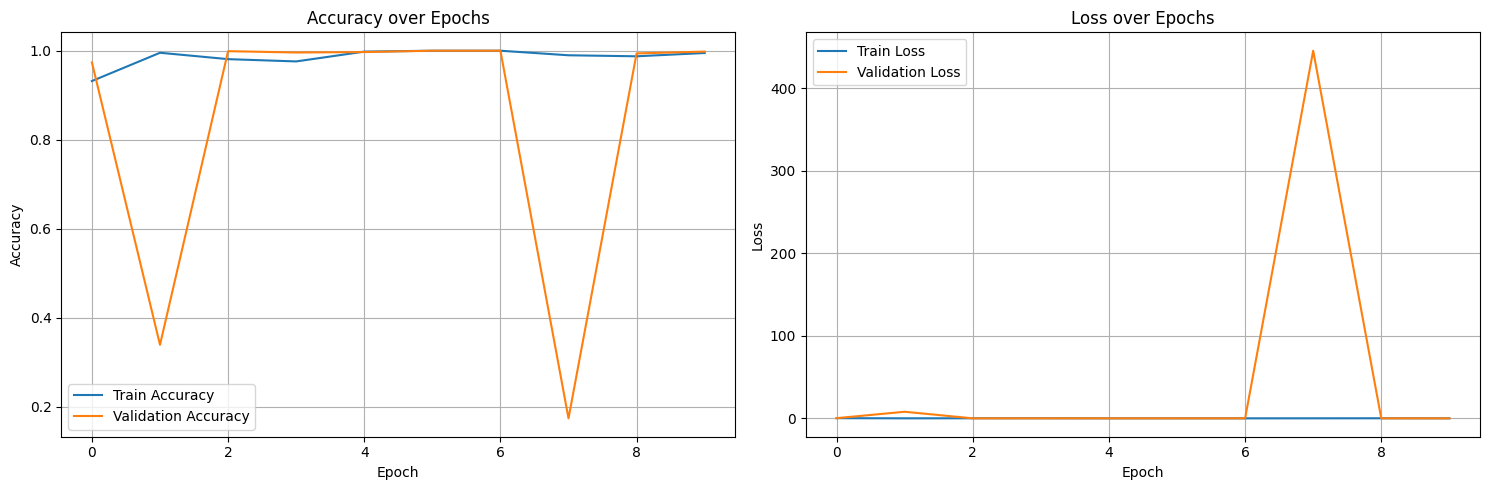

Training plot saved to /content/drive/MyDrive/StarSparkProj/training_results_plot_10epochs.png
Training history saved to /content/drive/MyDrive/StarSparkProj/training_history_10epochs.csv


In [ ]:
# Cell 6: Training Loop
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs_to_run): # Changed arg name for clarity
    if model is None or train_loader is None or val_loader is None:
        print("Model or Dataloaders not initialized. Training aborted.")
        return None

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    print(f"\nStarting training for {num_epochs_to_run} epochs on {device}...") # Use the passed argument

    for epoch in range(num_epochs_to_run): # Use the passed argument
        start_time_epoch = time.time()
        print(f"\nEpoch {epoch+1}/{num_epochs_to_run}") # Use the passed argument
        print("-" * 15)

        model.train()
        running_loss = 0.0
        correct_predictions_train = 0
        total_samples_train = 0

        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Train", leave=False)
        for inputs, labels in train_progress_bar:
            valid_mask = labels != -1
            if not valid_mask.any(): continue
            inputs, labels = inputs[valid_mask].to(device), labels[valid_mask].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions_train += torch.sum(preds == labels.data)
            total_samples_train += inputs.size(0)
            train_progress_bar.set_postfix({'loss': loss.item()})

        epoch_loss_train = running_loss / total_samples_train if total_samples_train > 0 else 0
        epoch_acc_train = correct_predictions_train.double() / total_samples_train if total_samples_train > 0 else 0
        history['train_loss'].append(epoch_loss_train)
        history['train_acc'].append(epoch_acc_train.item() if torch.is_tensor(epoch_acc_train) else epoch_acc_train)

        print(f"Train Loss: {epoch_loss_train:.4f} Acc: {epoch_acc_train:.4f}")

        model.eval()
        running_loss_val = 0.0
        correct_predictions_val = 0
        total_samples_val = 0

        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} Val", leave=False)
        with torch.no_grad():
            for inputs, labels in val_progress_bar:
                valid_mask = labels != -1
                if not valid_mask.any(): continue
                inputs, labels = inputs[valid_mask].to(device), labels[valid_mask].to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss_val += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions_val += torch.sum(preds == labels.data)
                total_samples_val += inputs.size(0)
                val_progress_bar.set_postfix({'loss': loss.item()})

        epoch_loss_val = running_loss_val / total_samples_val if total_samples_val > 0 else 0
        epoch_acc_val = correct_predictions_val.double() / total_samples_val if total_samples_val > 0 else 0
        history['val_loss'].append(epoch_loss_val)
        history['val_acc'].append(epoch_acc_val.item() if torch.is_tensor(epoch_acc_val) else epoch_acc_val)

        print(f"Val Loss: {epoch_loss_val:.4f} Acc: {epoch_acc_val:.4f}")

        if epoch_acc_val > best_val_accuracy and total_samples_val > 0:
            best_val_accuracy = epoch_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, BEST_MODEL_SAVE_PATH)
            print(f"Best model weights saved to {BEST_MODEL_SAVE_PATH} (Val Acc: {best_val_accuracy:.4f})")

        end_time_epoch = time.time()
        print(f"Epoch {epoch+1} completed in {(end_time_epoch - start_time_epoch)/60:.2f} minutes.")

    print("\nTraining complete.")
    print(f"Best Validation Accuracy achieved: {best_val_accuracy:.4f}")

    torch.save(model.state_dict(), TRAINED_MODEL_SAVE_PATH)
    print(f"Final trained model weights saved to {TRAINED_MODEL_SAVE_PATH}")

    return model, history

# --- Start Training ---
if model is not None and train_loader is not None and val_loader is not None:
    # NUM_EPOCHS is defined in Cell 2
    trained_model, training_history = train_model(model, criterion, optimizer, train_loader, val_loader, DEVICE, NUM_EPOCHS)

    if training_history:
        plot_training_results(training_history)
        history_df = pd.DataFrame(training_history)
        history_save_path = os.path.join(BASE_DIR, f"training_history_{NUM_EPOCHS}epochs.csv") # Filename reflects epochs
        history_df.to_csv(history_save_path, index=False)
        print(f"Training history saved to {history_save_path}")
else:
    print("Skipping training due to issues in model or data loader initialization.")